# Detecting Contrails

In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"  # JupyterLab
from pathlib import Path
import matplotlib.pyplot as plt
from contrai.utils.predict import predict

## 1. Select paths

In [3]:
YEAR = "2025"
MONTH = "04"
DAY = "03"
TIME = "1430"

In [4]:
from pathlib import Path

# Get current working directory
cwd = Path.cwd()

# Build paths relative to the current directory
from contrai.models.semantic_segmentation.coat.weight_loader import ensure_local_weight
from contrai.models.semantic_segmentation.coat.CoaT_U import CoaT_U

model = CoaT_U
model_path = ensure_local_weight("final")


image_path = cwd.parent / f"notebooks/images/goes16_ash_rgb/{YEAR}/{MONTH}/{DAY}/{TIME}/ash_rgb_0p02deg.png"
output_path = Path(str(image_path).replace("/images/", "/outputs/"))

# Safety checks
assert model_path.exists(), f"Model weights not found: {model_path}"
assert image_path.exists(), f"Image not found: {image_path}"

print("Using model:", model_path)


Using model: /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth


## 2. Run detection

### 2.1 Geojson output format

In [5]:
from contrai.data.goes16 import get_ash_rgb_pixel_geolocations
lat_grid, lon_grid = get_ash_rgb_pixel_geolocations(
)
geojson_fc = predict(model,
    model_path,
    image_path,
    product="geojson",
    lat=lat_grid,
    lon=lon_grid,
    coords=None,            # or (x1, x2, y1, y2) if cropped
    feature_id="contrail",
)


2025-11-19 10:47:48,245 | INFO | Using device: cuda
2025-11-19 10:47:48,246 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth
2025-11-19 10:47:48,995 | INFO | Running inference: tile_h=250 tile_w=250 stride=200 threshold=0.150


flip_y: True


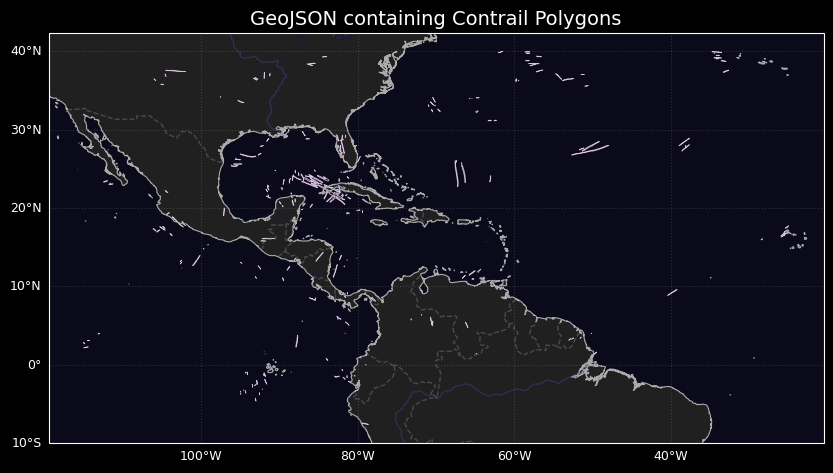

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_fc["features"])

# Dark background
plt.style.use("dark_background")

fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Ocean / land base
ax.add_feature(cfeature.OCEAN, facecolor="#0a0a1a")   # very dark blue
ax.add_feature(cfeature.LAND, facecolor="#202020")    # dark gray

# Coastlines + borders
ax.coastlines(resolution="10m", linewidth=0.8, color="#aaaaaa")
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.4, edgecolor="#888888")

# Lakes and rivers
ax.add_feature(cfeature.LAKES, facecolor="#1a1a3a", alpha=0.7)
ax.add_feature(cfeature.RIVERS, edgecolor="#4444aa", alpha=0.4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.15, linestyle=":")
gl.top_labels = gl.right_labels = False
gl.xlabel_style = {"color": "white", "size": 9}
gl.ylabel_style = {"color": "white", "size": 9}

# Plot GeoJSON geometry in a bright accent
gdf.plot(ax=ax, facecolor="none", edgecolor="#dac2e1", linewidth=0.5)

# Labels + Title
ax.set_title("GeoJSON containing Contrail Polygons", fontsize=14)

plt.show()


In [7]:
from contrai.utils.plot import plot_contrails_plotly_geo_pastel
fig = plot_contrails_plotly_geo_pastel(
    geojson_fc,
    title="GOES-16 Contrail Detection",
    subtitle=f"Ash RGB scene • {YEAR}-{MONTH}-{DAY} {TIME[:2]}:{TIME[2:]} UTC",
)
fig.show(config={"scrollZoom": True})
fig.write_html("contrail_demo.html", include_plotlyjs="cdn", full_html=True)

### 2.2 Binary mask output format

In [8]:
mask = predict(model,model_path, image_path, product="mask")

2025-11-19 10:49:45,925 | INFO | Using device: cuda
2025-11-19 10:49:45,927 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth
2025-11-19 10:49:46,509 | INFO | Running inference: tile_h=250 tile_w=250 stride=200 threshold=0.150


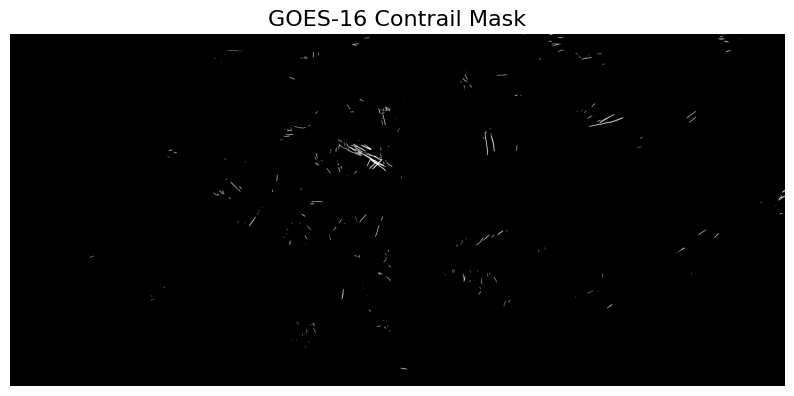

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(mask, cmap="gray")
ax.set_title("GOES-16 Contrail Mask", fontsize=16)
ax.axis("off")

plt.show()



### 2.3 Image overlay output format

In [9]:
overlay = predict(model,model_path, image_path, product="overlay")

2025-11-19 10:50:12,789 | INFO | Using device: cuda
2025-11-19 10:50:12,795 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth
2025-11-19 10:50:13,915 | INFO | Running inference: tile_h=250 tile_w=250 stride=200 threshold=0.150


## 3. Visualize

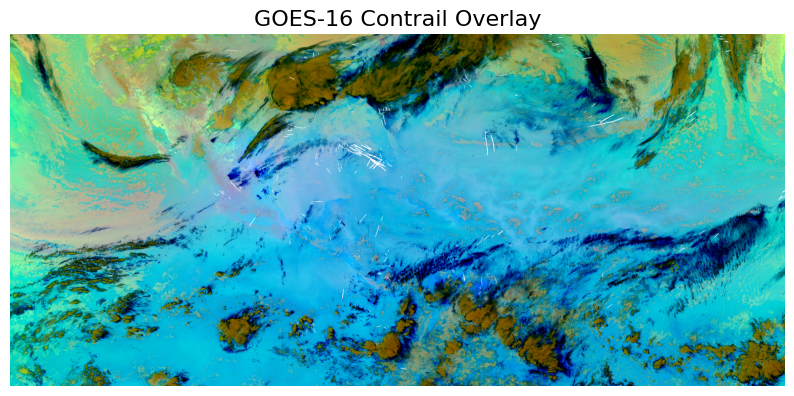

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(overlay)
ax.set_title("GOES-16 Contrail Overlay", fontsize=16)
ax.axis("off")

plt.show()


In [15]:

from contrai.utils.plot import plot_overlay_interactive_light
plot_overlay_interactive_light(overlay, title="GOES-16 Contrail Overlay")